# Paris Ratchet - Future Emissions

This script takes data from Climate Action Tracker and uses it to calculate the strength of the Paris Agreement's ratcheting mechanism. It then uses this to calculate possible future emissions trajectories under the Paris Ratchet

This assumes that 2030 emissions (as targets) are not affected by COVID-19 emissions, e.g. the UK's target of 68% reduction from 1990 level is not affected by the COVID rebound

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np


#plot setting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette('colorblind')
sns.set_style(style='ticks')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})


SNS_COLOURS = sns.color_palette().as_hex()
SNS_COLOURS = [SNS_COLOURS[-1]]+SNS_COLOURS[:-1]
sns.set_palette(SNS_COLOURS)

### Import historical GHG emissions
This is needed to estimate the strength of the Paris Agreement's ratcheting mechanism.

*Key Assumptions*
1. 2020/21 CO2 emissions will be 5.4 and 0.8% below 2019 levels (Global Carbon Project)
2. 2020/21 non-CO2 emissions will continue trend growth (not as affected) by the pandemic


In [2]:
#Import data
ghg_hist = pd.read_excel('./essd_ghg_data_gwp100.xlsx',sheet_name=2) 
#Data from Minx et al (2021): https://essd.copernicus.org/articles/13/5213/2021/essd-13-5213-2021-assets.html 
ghg_global = ghg_hist.groupby(['year']).sum()/1e9




ghg_global.loc[2020] = ghg_global.loc[2019] 
ghg_global.loc[2021] = ghg_global.loc[2019] 

#CO2 following GCP estimates
ghg_global.loc[2020,'CO2'] = ghg_global.loc[2019,'CO2']*(1-5.4/100)
ghg_global.loc[2021,'CO2'] = ghg_global.loc[2019,'CO2']*(1-0.8/100)

#Methane growing at 1%/y
ghg_global.loc[2020,'CH4'] = ghg_global.loc[2019,'CH4']*(
    ghg_global.loc[2019,'CH4']/ghg_global.loc[2009,'CH4'])**0.1
ghg_global.loc[2021,'CH4'] = ghg_global.loc[2020,'CH4']*(
    ghg_global.loc[2019,'CH4']/ghg_global.loc[2009,'CH4'])**0.1

#Nitrous oxide growing at 1%/y
ghg_global.loc[2020,'N2O'] = ghg_global.loc[2019,'N2O']*(
    ghg_global.loc[2019,'N2O']/ghg_global.loc[2009,'N2O'])**0.1
ghg_global.loc[2021,'N2O'] = ghg_global.loc[2020,'N2O']*(
    ghg_global.loc[2019,'N2O']/ghg_global.loc[2009,'N2O'])**0.1

#F gas growing at 4%/y
ghg_global.loc[2020,'Fgas'] = ghg_global.loc[2019,'Fgas']*(
    ghg_global.loc[2019,'Fgas']/ghg_global.loc[2009,'Fgas'])**0.1
ghg_global.loc[2021,'Fgas'] = ghg_global.loc[2020,'Fgas']*(
    ghg_global.loc[2019,'Fgas']/ghg_global.loc[2009,'Fgas'])**0.1


ghg_global.loc[2020,'GHG'] = ghg_global.loc[2020][:-1].sum()
ghg_global.loc[2021,'GHG'] = ghg_global.loc[2021][:-1].sum()



### Import data from Climate Action Tracker

This script uses data from Climate Action Tracker to estimate the strength of the Paris Agreement's ratcheting mechanism.

In [3]:
#Paris Outcomes
CurPol2030_Paris = 59
NDC2030_Paris = 54
#Source: https://climateactiontracker.org/documents/39/CAT_2015-10-01_INDCsLowerProjectedWarming_CATUpdate.pdf

#Glasgow Outcomes
CurPol2030_Glasgow = 52.74
NDC2030_Glasgow = 47
#Source: https://climateactiontracker.org/documents/997/CAT_2021-11-09_Briefing_Global-Update_Glasgow2030CredibilityGap.pdf

#Historical emissions according to CAT
GHG2015_CAT=50.63
GHG2016_CAT=50.58
GHG2017_CAT=51.29
GHG2018_CAT=51.94
GHG2019_CAT=52.04
GHG2020_CAT=49.37
# GHG2021_CAT=50.54 
#The direct data from CAT doesn't capture the rebound in emissions sufficiently
#Source: https://climateactiontracker.org/global/temperatures/

#Therefore we upscale 2021 number to account for the estimated rebound in emissions that occurred in 2021
GHG2021_CAT=GHG2020_CAT*ghg_global.loc[2021,'GHG']/ghg_global.loc[2020,'GHG']

#Estimating the COVID impact as the drop between 2021 emissions and expected trend based on 2015-19 emissions
COVID_impact=GHG2019_CAT+(GHG2019_CAT-GHG2015_CAT)/2-GHG2021_CAT


## Calculate Ratchet Strength

*Key assumption*: The COVID-19 impact on emissions declines linearly towards zero by 2030

There are 6 ways to calculate the ratchet - based on % rate changes (%/y), based on absolute rate changes (GtCO2/y), and based on absolute emissions (GtCO2). Each can be applied either to NDC trajectories or Current Policy trajectories

In [4]:
#Percentage Rate Ratchets

#Here the ratchet is defined by the change in % growth rates due to the first
#ratcheting cycle. Projects emissions fowards exponentially

#Rate of increase in GHGs from 2015-30 at Paris based on CurPol trajectories
ghg_rate_Paris_gr = (CurPol2030_Paris/GHG2015_CAT)**(1/15.0)

#Rate of increase in GHGs from 2021-30 at Glasgow based on CurPol trajectories
ghg_rate_Glasgow_gr = (CurPol2030_Glasgow/GHG2021_CAT)**(1/9.0)

ratchet_policy_gr=ghg_rate_Glasgow_gr-ghg_rate_Paris_gr


#Based on NDCS
#Rate of increase in GHGs from 2015-30 at Paris *IF* NDCs were met (using CAT)
ndc_rate_Paris_gr = (NDC2030_Paris/GHG2015_CAT)**(1/15.0)

#Rate of increase in GHGs from 2021-30 at Glasgow *IF* NDCs were met (using CAT)
ndc_rate_Glasgow_gr = (NDC2030_Glasgow/GHG2021_CAT)**(1/9.0)

ratchet_ndc_gr=ndc_rate_Glasgow_gr-ndc_rate_Paris_gr

In [5]:
#Absolute Rate Ratchets

#Here the ratchet is defined by the change in absolute growth rates due to the
#first ratcheting cycle. Projects emissions forwards linearly

#Rate of increase in GHGs from 2015-30 at Paris based on CurPol trajectories
ghg_rate_Paris_gr_abs = (CurPol2030_Paris-GHG2015_CAT)/15.0

#Rate of increase in GHGs from 2021-30 at Glasgow based on CurPol trajectories
ghg_rate_Glasgow_gr_abs = (CurPol2030_Glasgow-GHG2021_CAT)/9.0

ratchet_policy_gr_abs=ghg_rate_Glasgow_gr_abs-ghg_rate_Paris_gr_abs


#Based on NDCS
#Rate of increase in GHGs from 2015-30 at Paris *IF* NDCs were met (using CAT)
ndc_rate_Paris_gr_abs = (NDC2030_Paris-GHG2015_CAT)/15.0

#Rate of increase in GHGs from 2021-30 at Glasgow *IF* NDCs were met (using CAT)
ndc_rate_Glasgow_gr_abs = (NDC2030_Glasgow-GHG2021_CAT)/9.0

ratchet_ndc_gr_abs=ndc_rate_Glasgow_gr_abs-ndc_rate_Paris_gr_abs

In [7]:
#Absolute Emission Ratchets

#Estimated emissions in 2025 at Paris based on CurPol trajectories (a 10y forecast)
ghg_2025_Paris_abs = CurPol2030_Paris*2/3+GHG2015_CAT*1/3

#Estimated emissions in 2025 at Glasgow based on CurPol trajectories (a 5y forecast)
#We need to remove the effect of the Pandemic so we don't count this in
#absolute emissions. Assume that the effect declines linearly to zero by 2030
ghg_2025_Glasgow_abs = (CurPol2030_Glasgow*4+GHG2021_CAT*5)/9+COVID_impact/2


ratchet_policy_abs=ghg_2025_Glasgow_abs-ghg_2025_Paris_abs


#Based on NDCS
#Estimated emissions in 2025 at Paris based on NDC trajectories (a 10y forecast)
ndc_2025_Paris_abs = NDC2030_Paris*2/3+GHG2015_CAT/3

#Estimated emissions in 2025 at Glasgow based on NDC trajectories (a 5y forecast)
#We need to remove the effect of the Pandemic so we don't count this in
#absolute emissions. Assume that the effect declines linearly to zero by 2030
ndc_2025_Glasgow_abs = (NDC2030_Glasgow*4+GHG2021_CAT*5)/9+COVID_impact/2



ratchet_ndc_abs=ndc_2025_Glasgow_abs-ndc_2025_Paris_abs


In [8]:

#Save ratchets
ratchets = pd.DataFrame(data=[[ratchet_ndc_gr,ratchet_ndc_gr_abs,ratchet_ndc_abs],
                              [ratchet_policy_gr,ratchet_policy_gr_abs,
                               ratchet_policy_abs]],
                        index=['NDC','CurPol'],
                        columns=['%rate','abs_rate','abs_emissions'])


### Plot the impact of ratcheting between Paris and Glasgow

Text(0.5, 1.0, '$\\mathbf{The\\/Paris\\/ratcheting\\/mechanism}$')

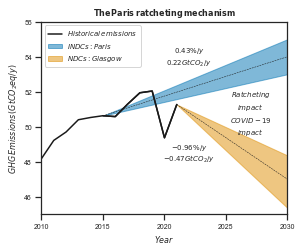

In [9]:

mm = 1/25.4  # millimetres in inches
fig1, ax = plt.subplots(figsize=(112*mm,90*mm))

ax.plot(np.linspace(2010,2021,12),
        [48.18,49.22,49.70,50.40,50.53,GHG2015_CAT,GHG2016_CAT,GHG2017_CAT,
        GHG2018_CAT,GHG2019_CAT,GHG2020_CAT,GHG2021_CAT],color='k')

#plot the 2015 NDCs
ax.fill_between(np.linspace(2015,2030,16),
                np.linspace(GHG2015_CAT,55,16),
                np.linspace(GHG2015_CAT,53,16),
                alpha=0.5,
                color=SNS_COLOURS[1])



#plot the 2021 NDCs
ax.fill_between(np.linspace(2021,2030,10),
                np.linspace(GHG2021_CAT,48.36,10),
                np.linspace(GHG2021_CAT,
                            45.36,10),
                alpha=0.5,
                color=SNS_COLOURS[2])


ax.legend(['$Historical\/emissions$',
            '$INDCs:Paris$',
            '$NDCs:Glasgow$'],fontsize=7)
ax.plot(np.linspace(2015,2021,7),[GHG2015_CAT,GHG2016_CAT,GHG2017_CAT,
                                  GHG2018_CAT,GHG2019_CAT,GHG2020_CAT,
                                  GHG2021_CAT],color='k')

ax.plot(np.linspace(2015,2030,16),np.linspace(GHG2015_CAT,54,16),
        color='k',linewidth=0.5,linestyle='--')
ax.plot(np.linspace(2021,2030,10),
        np.linspace(GHG2021_CAT,
                    NDC2030_Glasgow,10),
        color='k',linewidth=0.5,linestyle='--')


ax.set_xlim([2010,2030])
ax.set_ylim([45,56])

ax.text(2022,53.5,'$0.43\%/y$'+'\n'+'$0.22GtCO_{2}/y$',
        horizontalalignment='center',fontsize=7)
ax.text(2022,48,'$-0.96\%/y$'+'\n'+'$-0.47GtCO_{2}/y$',
        horizontalalignment='center',fontsize=7)


ax.text(2027,50,'$COVID-19$'+'\n'+'$impact$',
        horizontalalignment='center',verticalalignment='center',
        fontsize=7)
ax.text(2027,51.5,'$Ratcheting$'+'\n'+'$impact$',
        horizontalalignment='center',verticalalignment='center',
        fontsize=7)

ax.set_xticks([2010,2015,2020,2025,2030])
ax.set_xticklabels([2010,2015,2020,2025,2030],fontsize=7)
ax.set_xlabel('$Year$',fontsize=8)

ax.set_yticks([46,48,50,52,54,56])
ax.set_yticklabels([46,48,50,52,54,56],fontsize=7)
ax.set_ylabel('$GHG\/Emissions\/(GtCO_{2}eq/y)$',fontsize=8)

ax.set_title('$\mathbf{The\/Paris\/ratcheting\/mechanism}$',
             fontsize=8)

## Applying the ratchet to estimate future emissions

The following function calculates future emissions based on one of the above ratcheting principles - percentage rates, absolute  rates, or absolute emissions.

The default assumption (if strength=1) is that the first Paris ratchet as defined above is repeated every 5 years. Strengthening the ratchet strengthens the level of change in a 5 year cycle. We assume that when net-zero GHG are met (as described in the Paris Agreement) that emissions stabilise at net-zero.


In [10]:

years = np.linspace(2015,2100,86)



def paris_ratchet(t,ratchet,strength,ratchet_type):  
    valid={'gr_%','gr_abs','abs'}
    if ratchet_type not in valid:
        raise ValueError("error: ratchet_type must be one of %r" % valid)    
        
    future_ghg = np.array([])

    #calculate future emissions for % growth rate changes    
    if ratchet_type=='gr_%':       
        for i in range(len(years)):
            if years[i]<=2021:
                future_ghg=np.append(future_ghg,ghg_global.loc[years[i],'GHG'])
            
            if years[i]>2021:
                
                ghg = future_ghg[-1]*(
                    ghg_rate_Glasgow_gr+ratchet*strength/5*(years[i]-2021)
                    )**(years[i]-years[i-1])
                future_ghg=np.append(future_ghg,ghg)
 
    #calculate future emissions for absolute growth rate changes
    if ratchet_type=='gr_abs':       
        for i in range(len(years)):
            if years[i]<=2021:
                future_ghg=np.append(future_ghg,ghg_global.loc[years[i],'GHG'])
            
            if years[i]>2021:
                
                ghg = future_ghg[-1]+(
                    ghg_rate_Glasgow_gr_abs+ratchet*strength/5*(years[i]-2021)
                    )*(years[i]-years[i-1])
                
                future_ghg=np.append(future_ghg,ghg)

    #calculate future emissions based on absolute emissions -
    #this currently uses five-year intervals to calculate the ratchet                
    if ratchet_type=='abs':
        years_5y = np.linspace(2015,2100,18)
        gr_abs = ghg_rate_Glasgow_gr_abs
        
        for i in range(len(years_5y)):
            if years_5y[i]<=2021:
                future_ghg=np.append(future_ghg,ghg_global.loc[years_5y[i],'GHG'])
            
            if years_5y[i]==2025:
                future_ghg=np.append(future_ghg,
                                     (ghg_global.loc[2021,'GHG']+
                                      gr_abs*4))
                gr_abs=gr_abs+ratchet*strength/5
                
            
            if years_5y[i]>2025:
                ghg = future_ghg[-1]+gr_abs*5              
                gr_abs=gr_abs+ratchet*strength/5
                              
                future_ghg=np.append(future_ghg,ghg)
                
        future_ghg=np.append(ghg_global.loc[2015:2020,'GHG'],
                             np.append(np.interp(np.linspace(2021,2025,5),
                                       np.array([2021,2025]),
                                       np.array([ghg_global.loc[2021,'GHG'],
                                                 future_ghg[2]])),
                             np.interp(np.linspace(2025,2100,76),
                                       years_5y[2:],
                                       future_ghg[2:])[1:]))
                
    # code to replace all negative value with 0 - as otherwise the
    #absolute emissions profiles behave strangely with escalating negative 
    #emissions
    future_ghg[future_ghg<0] = 0         
                
    return future_ghg
    

In [11]:
#Future ratcheting with the percentage rate ratchet
future_ghg_gr = pd.DataFrame(data=[years,
                                paris_ratchet(years,ratchet_ndc_gr,1,'gr_%'),
                                paris_ratchet(years,ratchet_ndc_gr,2,'gr_%'),
                                paris_ratchet(years,ratchet_ndc_gr,3,'gr_%'),
                                paris_ratchet(years,ratchet_ndc_gr,4,'gr_%'),
                                paris_ratchet(years,ratchet_ndc_gr,5,'gr_%'),
                                paris_ratchet(years,ratchet_ndc_gr,6,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,1,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,2,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,3,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,4,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,5,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,6,'gr_%'),
                                paris_ratchet(years,ratchet_policy_gr,8,'gr_%')],
                          index=['Years',
                                 'ratchet_ndc','2ratchet_ndc','3ratchet_ndc',
                                 '4ratchet_ndc','5ratchet_ndc','6ratchet_ndc',
                                 'ratchet_policy','2ratchet_policy',
                                 '3ratchet_policy','4ratchet_policy',
                                 '5ratchet_policy','6ratchet_policy',
                                 '8ratchet_policy']).T


In [12]:
#Future ratcheting with the absolute rate ratchet
future_ghg_gr_abs = pd.DataFrame(data=[years,
                                paris_ratchet(years,ratchet_ndc_gr_abs,1,'gr_abs'),
                                paris_ratchet(years,ratchet_ndc_gr_abs,2,'gr_abs'),
                                paris_ratchet(years,ratchet_ndc_gr_abs,3,'gr_abs'),
                                paris_ratchet(years,ratchet_ndc_gr_abs,4,'gr_abs'),
                                paris_ratchet(years,ratchet_ndc_gr_abs,5,'gr_abs'),
                                paris_ratchet(years,ratchet_ndc_gr_abs,6,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,1,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,2,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,3,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,4,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,5,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,6,'gr_abs'),
                                paris_ratchet(years,ratchet_policy_gr_abs,8,'gr_abs')],
                          index=['Years',
                                 'ratchet_ndc','2ratchet_ndc','3ratchet_ndc',
                                 '4ratchet_ndc','5ratchet_ndc','6ratchet_ndc',
                                 'ratchet_policy','2ratchet_policy',
                                 '3ratchet_policy','4ratchet_policy',
                                 '5ratchet_policy','6ratchet_policy',
                                 '8ratchet_policy']).T


In [13]:
#Future ratcheting with the absolute emissions ratchet
future_ghg_abs = pd.DataFrame(data=[years,
                                paris_ratchet(years,ratchet_ndc_abs,1,'abs'),
                                paris_ratchet(years,ratchet_ndc_abs,2,'abs'),
                                paris_ratchet(years,ratchet_ndc_abs,3,'abs'),
                                paris_ratchet(years,ratchet_ndc_abs,4,'abs'),
                                paris_ratchet(years,ratchet_ndc_abs,5,'abs'),
                                paris_ratchet(years,ratchet_ndc_abs,6,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,1,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,2,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,3,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,4,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,5,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,6,'abs'),
                                paris_ratchet(years,ratchet_policy_abs,8,'abs')],
                          index=['Years',
                                 'ratchet_ndc','2ratchet_ndc','3ratchet_ndc',
                                 '4ratchet_ndc','5ratchet_ndc','6ratchet_ndc',
                                 'ratchet_policy','2ratchet_policy',
                                 '3ratchet_policy','4ratchet_policy',
                                 '5ratchet_policy','6ratchet_policy',
                                 '8ratchet_policy']).T

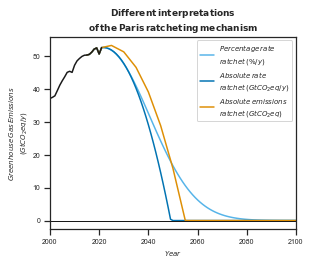

In [14]:
#Show the implications of future ratcheting with different mechanisms

fig2, ax = plt.subplots(figsize=(112*mm,90*mm))
sns.lineplot(x='Years',y='ratchet_ndc',data=future_ghg_gr)
sns.lineplot(x='Years',y='ratchet_ndc',data=future_ghg_gr_abs)
sns.lineplot(x='Years',y='ratchet_ndc',data=future_ghg_abs)
sns.lineplot(x='year',y='GHG',data=ghg_global,color='k')

ax.set_xlim([2000,2100])
ax.set_xlabel('$Year$',size=7)
ax.set_xticks([2000,2020,2040,2060,2080,2100])
ax.set_xticklabels([2000,2020,2040,2060,2080,2100],fontsize=7)

ax.set_ylabel('$Greenhouse\/Gas\/Emissions$'+'\n'+
              '$(GtCO_{2}eq/y)$',size=7)
ax.set_yticks([0,10,20,30,40,50])
ax.set_yticklabels([0,10,20,30,40,50],fontsize=7)


ax.legend(['$Percentage\/rate$'+'\n'+'$ratchet\/(\%/y)$',
           '$Absolute\/rate$'+'\n'+'$ratchet\/(GtCO_{2}eq/y)$',
           '$Absolute\/emissions$'+'\n'+'$ratchet\/(GtCO_{2}eq)$'],
          loc='upper right',fontsize=7)

ax.set_title('$\mathbf{Different\/interpretations}$'+'\n'+
             '$\mathbf{of\/the\/Paris\/ratcheting\/mechanism}$',
             fontsize=9)
ax.axhline(y=0, color='k', linewidth=1)


### Save future GHG trajectories for Silicone disaggregation
We now save these stylised future greenhouse gas trajectories ready to be used as inputs for Silicone disaggregation.

In [18]:
past_ghg=pd.concat([ghg_global.loc[2010:2014,'GHG']]*13,axis=1).reset_index()
past_ghg.columns=future_ghg_gr.columns

#Percentage rate approach
future_ghg_gr_silicone=pd.concat([past_ghg,future_ghg_gr]).reset_index(drop=True)
future_ghg_gr_silicone.columns=pd.MultiIndex.from_tuples(
    zip(['Years']+['paris_ratchet']*13,future_ghg_gr_silicone.columns),
    names=['model','scenario'])
future_ghg_gr_silicone.set_index(future_ghg_gr_silicone.columns[0],inplace=True)
future_ghg_gr_silicone.to_csv(
    './Silicone/silicone_inputs/ratcheted_emissions_gr.csv',index=True)

#Absolute rate approach
future_ghg_gr_abs_silicone=pd.concat([past_ghg,future_ghg_gr_abs]).reset_index(drop=True)
future_ghg_gr_abs_silicone.columns=pd.MultiIndex.from_tuples(
    zip(['Years']+['paris_ratchet']*13,future_ghg_gr_abs_silicone.columns),
    names=['model','scenario'])
future_ghg_gr_abs_silicone.set_index(future_ghg_gr_abs_silicone.columns[0],inplace=True)
future_ghg_gr_abs_silicone.to_csv(
    './Silicone/silicone_inputs/ratcheted_emissions_gr_abs.csv',index=True)

#Absolute emissions approach
future_ghg_abs_silicone=pd.concat([past_ghg,future_ghg_abs]).reset_index(drop=True)
future_ghg_abs_silicone.columns=pd.MultiIndex.from_tuples(
    zip(['Years']+['paris_ratchet']*13,future_ghg_abs_silicone.columns),
    names=['model','scenario'])
future_ghg_abs_silicone.set_index(future_ghg_abs_silicone.columns[0],inplace=True)
future_ghg_abs_silicone.to_csv(
    './Silicone/silicone_inputs/ratcheted_emissions_abs.csv',index=True)
